## 0) Setup

In [1]:
# If needed: !pip install -q scikit-learn imbalanced-learn pandas numpy matplotlib
import os, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib


## 1) Load the dataset

In [3]:
# Try to auto-detect a CSV in the current folder that likely matches the dataset
DATA_PATH = "/content/loan_approval_dataset.csv"
for f in glob.glob("*.csv"):
    if "loan" in f.lower():
        DATA_PATH = f
        break

# If not found automatically, set it manually (uncomment and edit):
# DATA_PATH = "/path/to/Loan_Approval_Prediction.csv"

assert DATA_PATH is not None, "Please set DATA_PATH to the Kaggle CSV file."

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 2) Quick EDA checks (non-plotting, fast)

In [6]:
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Drop obvious ID columns if present
id_cols = [c for c in df.columns if "id" in c.lower()]
if id_cols:
    df = df.drop(columns=id_cols)
    print("\nDropped ID columns:", id_cols)

# Identify the target column (common: 'Loan_Status')
possible_targets = [c for c in df.columns if c.lower() in ("loan_status","status","approved","approval_status")]
assert len(possible_targets) >= 1, "Target column not found. Rename your target to 'Loan_Status' (Y/N) or add it to possible_targets."
target_col = possible_targets[0]
print("Target column:", target_col)

# Separate features/target
y_raw = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Map/encode target: if strings like Y/N, encode to 1/0
if y_raw.dtype == 'O':
    # Try common mapping first:
    map_try = y_raw.astype(str).str.upper().map({'Y':1, 'N':0})
    if map_try.isna().mean() < 0.5:  # worked for most rows
        y = map_try.fillna(0).astype(int)
        target_mapping = {'Y':1, 'N':0}
    else:
        # Fallback: LabelEncode generic categories
        le = LabelEncoder()
        y = le.fit_transform(y_raw.astype(str))
        target_mapping = {cls: int(code) for cls, code in zip(le.classes_, range(len(le.classes_)))}
else:
    y = y_raw.astype(int)
    target_mapping = None

print("\nTarget value counts (encoded):")
print(pd.Series(y).value_counts())

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

Columns: [' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']

Dtypes:
 no_of_dependents            int64
education                  object
self_employed              object
income_annum                int64
loan_amount                 int64
loan_term                   int64
cibil_score                 int64
commercial_assets_value     int64
luxury_assets_value         int64
bank_asset_value            int64
loan_status                object
dtype: object

Missing values per column:
 no_of_dependents           0
education                  0
self_employed              0
income_annum               0
loan_amount                0
loan_term                  0
cibil_score                0
commercial_assets_value    0
luxury_assets_value        0
bank_asset_value           0
loan_status                0
dtype: int64
Target column: loan_status

## 3) Preprocessing pipelines

In [8]:
# Selectors
num_features = selector(dtype_include=np.number)(X_train)
cat_features = selector(dtype_exclude=np.number)(X_train)

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # For small feature sets, dense is fine. If you expect many categories, remove sparse=False.
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop"
)

Numeric features: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical features: ['education', 'self_employed']


## 4) Helper: evaluation & plotting

In [9]:
def evaluate_and_report(model, X_test, y_test, title="Model"):
    y_pred = model.predict(X_test)
    print(f"\n=== {title} :: Test Classification Report ===")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    try:
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.title(f"{title} - Confusion Matrix")
        plt.show()
    except Exception:
        pass

    # Probabilities for curves
    y_score = None
    try:
        y_score = model.predict_proba(X_test)[:, 1]
    except Exception:
        pass

    if y_score is not None:
        roc = roc_auc_score(y_test, y_score)
        pr_auc = average_precision_score(y_test, y_score)
        print(f"ROC-AUC: {roc:.4f}")
        print(f"Average Precision (PR AUC): {pr_auc:.4f}")

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{title} - ROC Curve (AUC={roc:.3f})")
        plt.show()

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{title} - Precision-Recall Curve (AP={pr_auc:.3f})")
        plt.show()


## 5) Baseline (no SMOTE) vs. SMOTE pipelines

In [10]:
# Logistic Regression
lr_baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

lr_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# Decision Tree
dt_baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", DecisionTreeClassifier(random_state=42))
])


## 6) Train & evaluate (test set)

In [12]:
# Fit
lr_baseline.fit(X_train, y_train)
dt_baseline.fit(X_train, y_train)
lr_smote.fit(X_train, y_train)
dt_smote.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education',
                                                   'self_employed'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier(random_state=42))])


=== Logistic Regression (No SMOTE) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9267    0.9529    0.9396       531
           1     0.9188    0.8762    0.8970       323

    accuracy                         0.9239       854
   macro avg     0.9228    0.9145    0.9183       854
weighted avg     0.9237    0.9239    0.9235       854

Confusion Matrix:
 [[506  25]
 [ 40 283]]


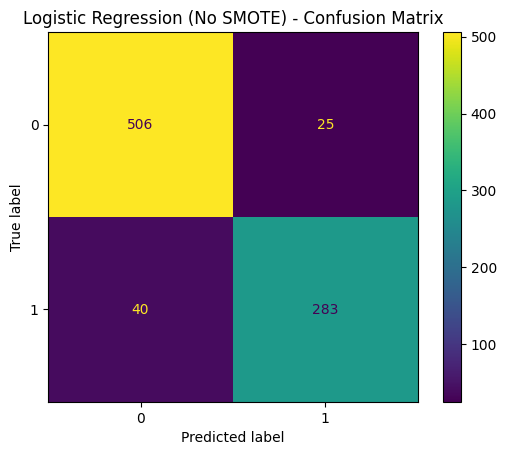

ROC-AUC: 0.9745
Average Precision (PR AUC): 0.9536


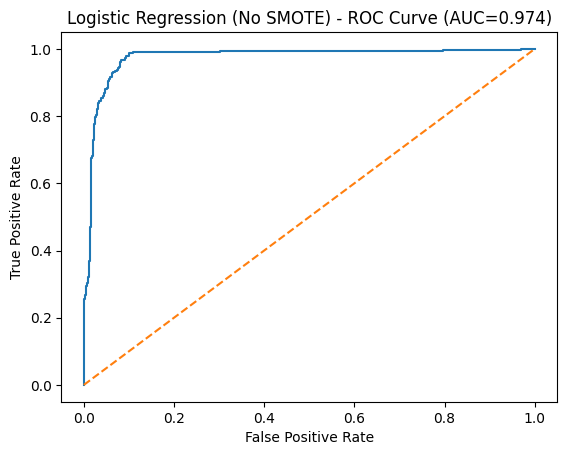

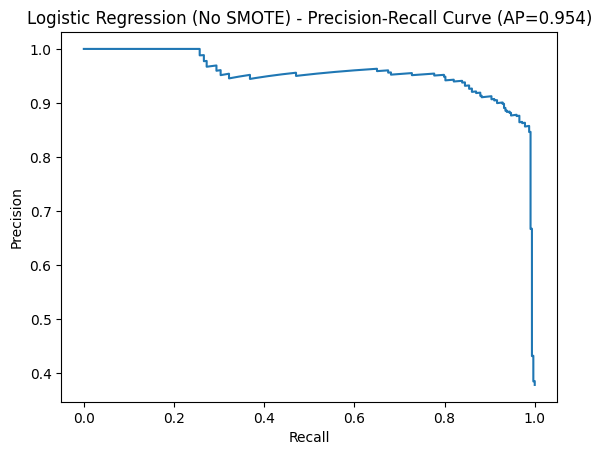


=== Decision Tree (No SMOTE) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9738    0.9812    0.9775       531
           1     0.9687    0.9567    0.9626       323

    accuracy                         0.9719       854
   macro avg     0.9712    0.9689    0.9701       854
weighted avg     0.9719    0.9719    0.9719       854

Confusion Matrix:
 [[521  10]
 [ 14 309]]


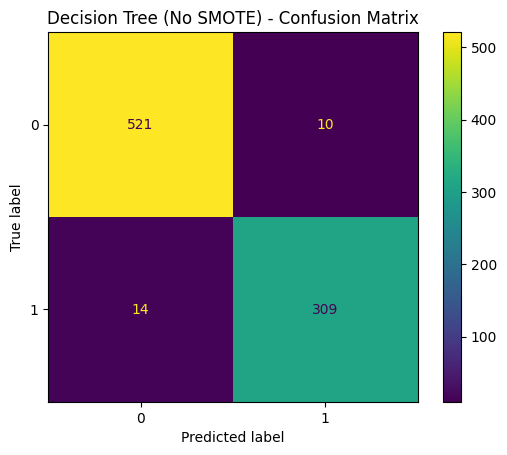

ROC-AUC: 0.9689
Average Precision (PR AUC): 0.9431


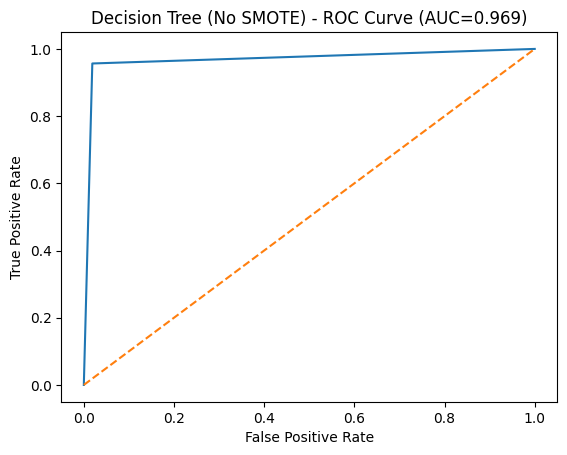

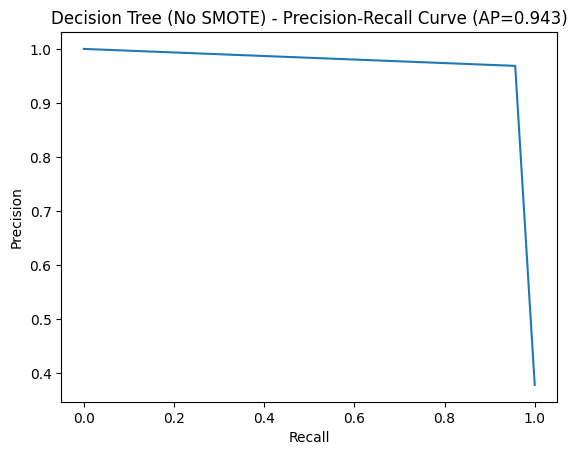


=== Logistic Regression (SMOTE) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9489    0.9435    0.9462       531
           1     0.9080    0.9164    0.9122       323

    accuracy                         0.9333       854
   macro avg     0.9284    0.9300    0.9292       854
weighted avg     0.9334    0.9333    0.9333       854

Confusion Matrix:
 [[501  30]
 [ 27 296]]


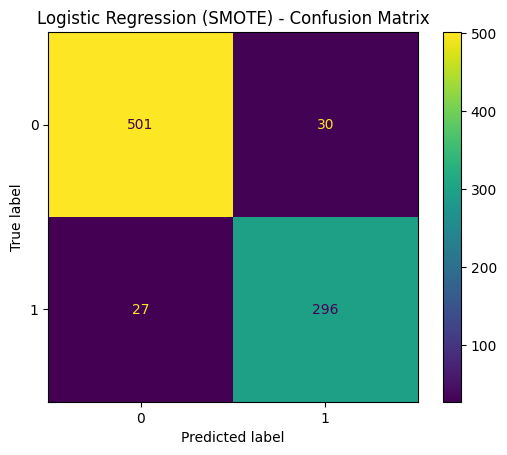

ROC-AUC: 0.9747
Average Precision (PR AUC): 0.9530


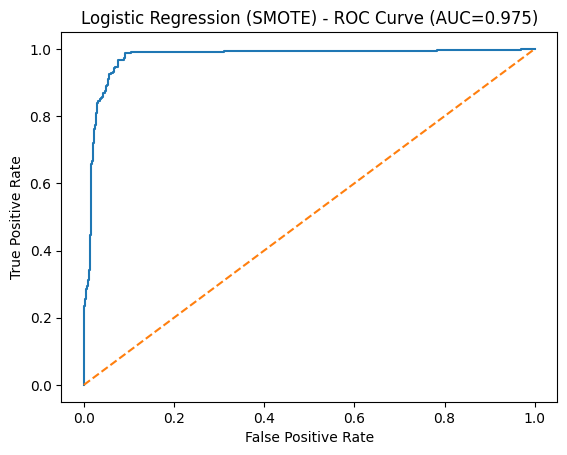

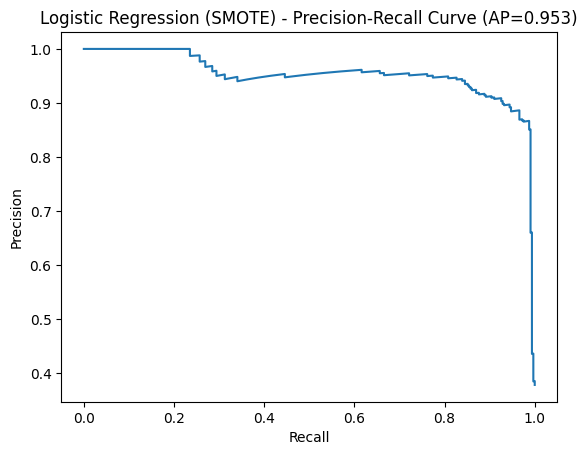


=== Decision Tree (SMOTE) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9757    0.9812    0.9784       531
           1     0.9688    0.9598    0.9642       323

    accuracy                         0.9731       854
   macro avg     0.9722    0.9705    0.9713       854
weighted avg     0.9730    0.9731    0.9730       854

Confusion Matrix:
 [[521  10]
 [ 13 310]]


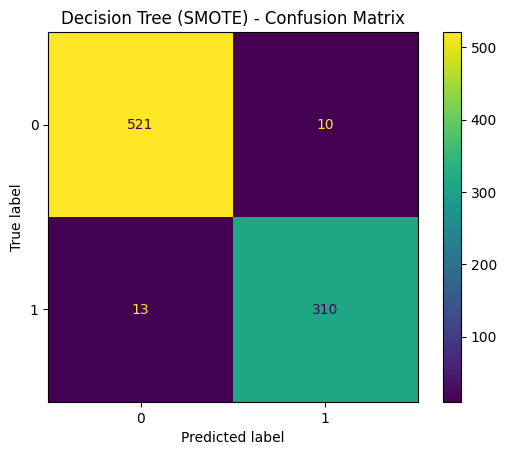

ROC-AUC: 0.9705
Average Precision (PR AUC): 0.9450


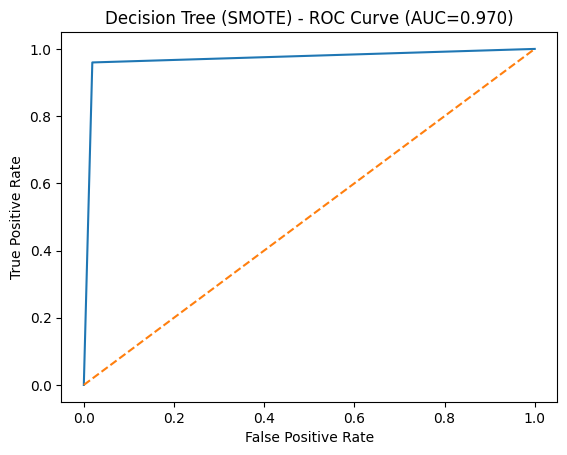

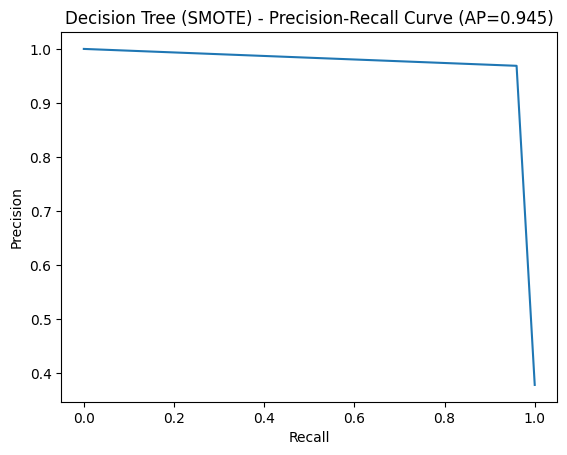

In [13]:

# Evaluate
evaluate_and_report(lr_baseline, X_test, y_test, "Logistic Regression (No SMOTE)")
evaluate_and_report(dt_baseline, X_test, y_test, "Decision Tree (No SMOTE)")
evaluate_and_report(lr_smote, X_test, y_test, "Logistic Regression (SMOTE)")
evaluate_and_report(dt_smote, X_test, y_test, "Decision Tree (SMOTE)")

## 7) Cross-validation with focus on Precision/Recall/F1

In [14]:
scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision"
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_summary(name, pipe):
    cv_res = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    mean_scores = {k.replace("test_", ""): np.mean(v) for k, v in cv_res.items() if k.startswith("test_")}
    print(f"\n{name} - CV (mean over 5 folds):")
    for m, val in mean_scores.items():
        print(f"  {m:>14}: {val:.4f}")

cv_summary("LR (No SMOTE)", lr_baseline)
cv_summary("DT (No SMOTE)", dt_baseline)
cv_summary("LR (SMOTE)", lr_smote)
cv_summary("DT (SMOTE)", dt_smote)



LR (No SMOTE) - CV (mean over 5 folds):
       precision: 0.8916
          recall: 0.8878
              f1: 0.8895
         roc_auc: 0.9682
   avg_precision: 0.9406

DT (No SMOTE) - CV (mean over 5 folds):
       precision: 0.9705
          recall: 0.9740
              f1: 0.9722
         roc_auc: 0.9779
   avg_precision: 0.9551

LR (SMOTE) - CV (mean over 5 folds):
       precision: 0.8699
          recall: 0.9318
              f1: 0.8997
         roc_auc: 0.9681
   avg_precision: 0.9383

DT (SMOTE) - CV (mean over 5 folds):
       precision: 0.9627
          recall: 0.9727
              f1: 0.9677
         roc_auc: 0.9749
   avg_precision: 0.9468


## 8) Hyperparameter tuning (GridSearch) with SMOTE

Best LR params: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

=== Best Logistic Regression (SMOTE) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9747    0.9416    0.9579       531
           1     0.9091    0.9598    0.9337       323

    accuracy                         0.9485       854
   macro avg     0.9419    0.9507    0.9458       854
weighted avg     0.9499    0.9485    0.9487       854

Confusion Matrix:
 [[500  31]
 [ 13 310]]


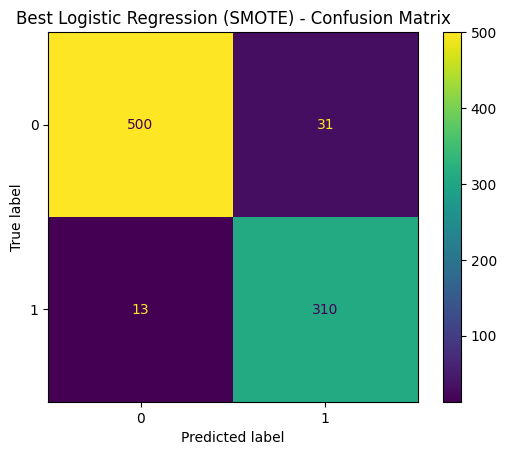

ROC-AUC: 0.9746
Average Precision (PR AUC): 0.9491


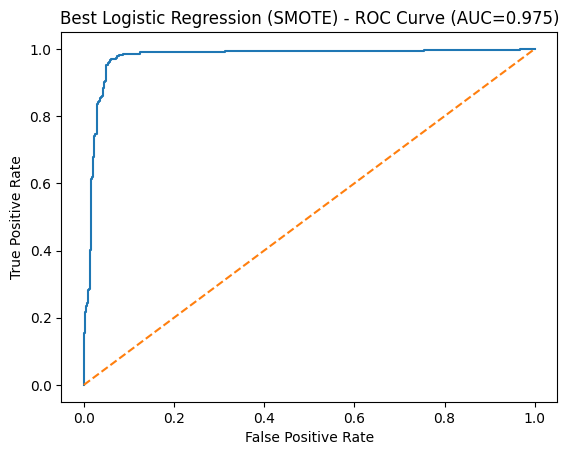

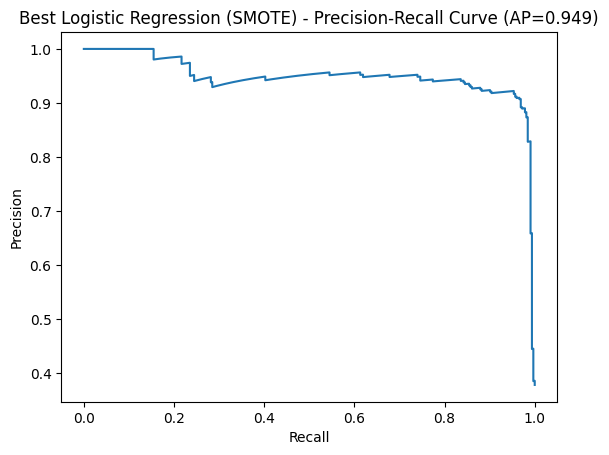

Best DT params: {'model__ccp_alpha': 0.001, 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}

=== Best Decision Tree (SMOTE) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9740    0.9887    0.9813       531
           1     0.9810    0.9567    0.9687       323

    accuracy                         0.9766       854
   macro avg     0.9775    0.9727    0.9750       854
weighted avg     0.9766    0.9766    0.9765       854

Confusion Matrix:
 [[525   6]
 [ 14 309]]


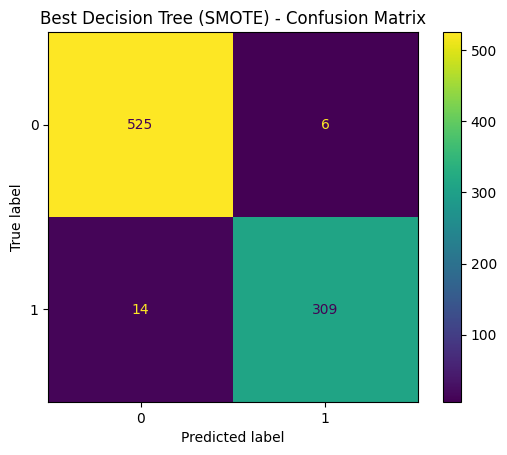

ROC-AUC: 0.9887
Average Precision (PR AUC): 0.9813


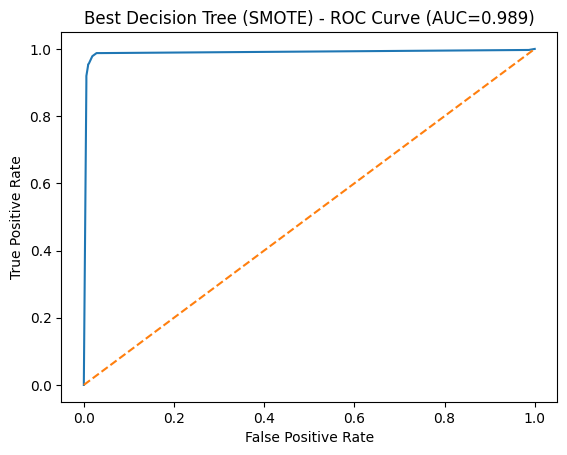

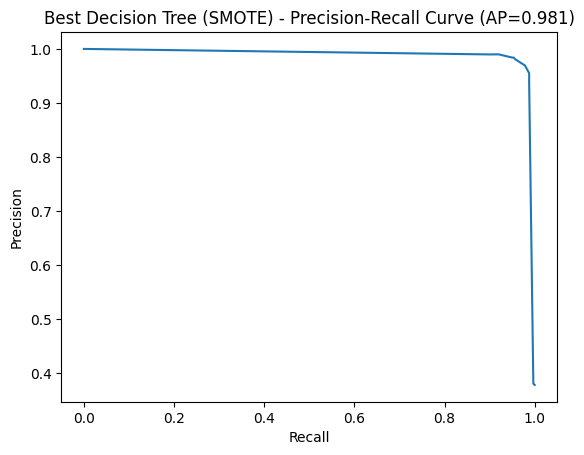

In [15]:
# Logistic Regression grid
lr_grid = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs", "liblinear"],
    "model__penalty": ["l2"]  # l1 works with liblinear/saga, add if needed
}

gs_lr = GridSearchCV(
    lr_grid, param_grid_lr, scoring="f1", cv=skf, n_jobs=-1, refit=True, verbose=0
)
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_)
best_lr = gs_lr.best_estimator_
evaluate_and_report(best_lr, X_test, y_test, "Best Logistic Regression (SMOTE)")

# Decision Tree grid
dt_grid = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__ccp_alpha": [0.0, 0.001, 0.01]
}

gs_dt = GridSearchCV(
    dt_grid, param_grid_dt, scoring="f1", cv=skf, n_jobs=-1, refit=True, verbose=0
)
gs_dt.fit(X_train, y_train)
print("Best DT params:", gs_dt.best_params_)
best_dt = gs_dt.best_estimator_
evaluate_and_report(best_dt, X_test, y_test, "Best Decision Tree (SMOTE)")


## 9)Alternative to SMOTE: class_weight


=== Logistic Regression (class_weight=balanced) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9543    0.9435    0.9489       531
           1     0.9088    0.9257    0.9172       323

    accuracy                         0.9368       854
   macro avg     0.9316    0.9346    0.9330       854
weighted avg     0.9371    0.9368    0.9369       854

Confusion Matrix:
 [[501  30]
 [ 24 299]]


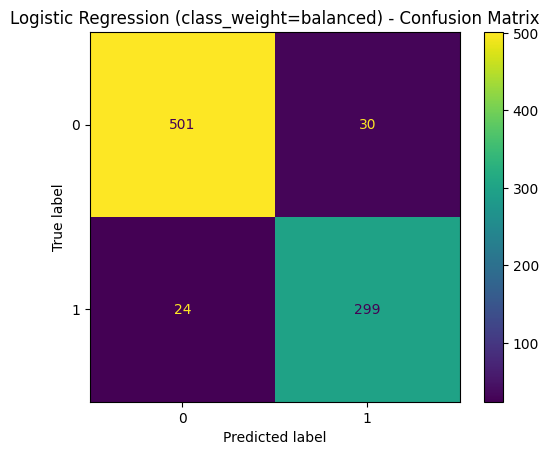

ROC-AUC: 0.9747
Average Precision (PR AUC): 0.9522


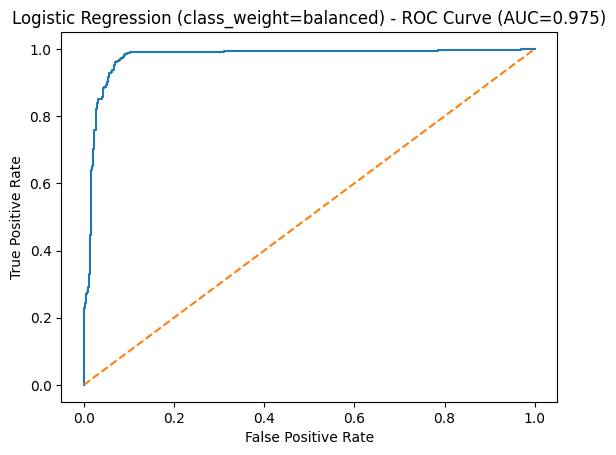

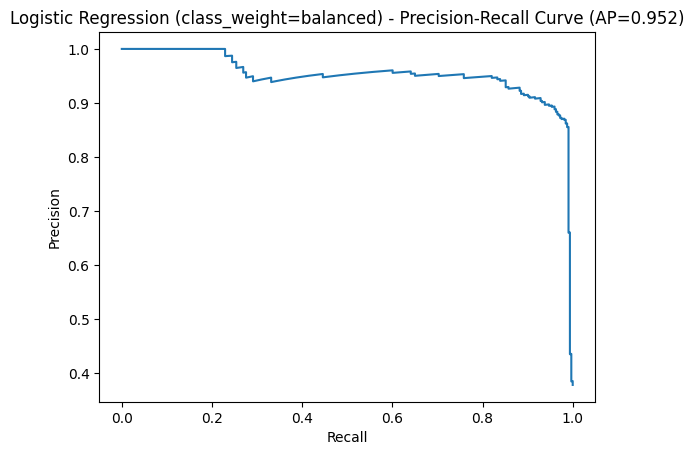


=== Decision Tree (class_weight=balanced) :: Test Classification Report ===
              precision    recall  f1-score   support

           0     0.9699    0.9718    0.9708       531
           1     0.9534    0.9505    0.9519       323

    accuracy                         0.9637       854
   macro avg     0.9617    0.9611    0.9614       854
weighted avg     0.9637    0.9637    0.9637       854

Confusion Matrix:
 [[516  15]
 [ 16 307]]


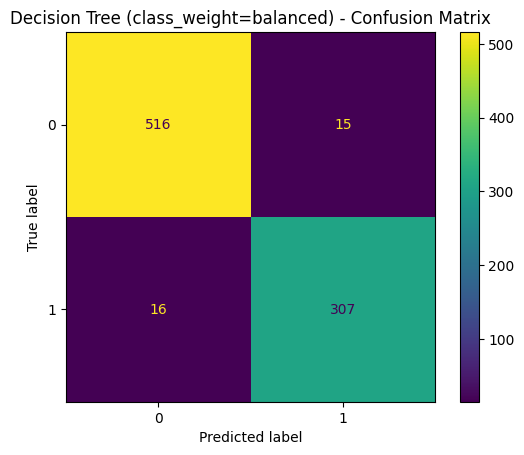

ROC-AUC: 0.9611
Average Precision (PR AUC): 0.9249


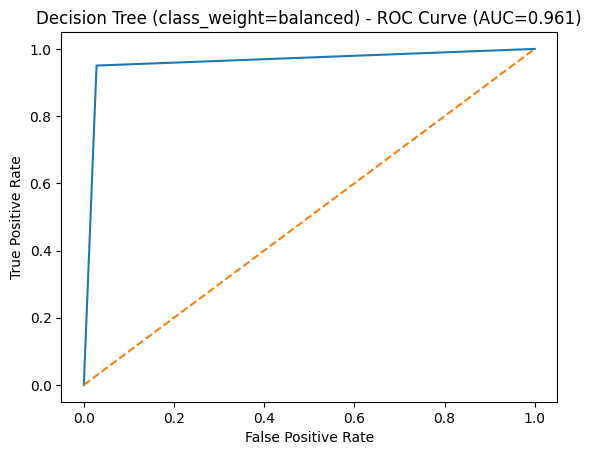

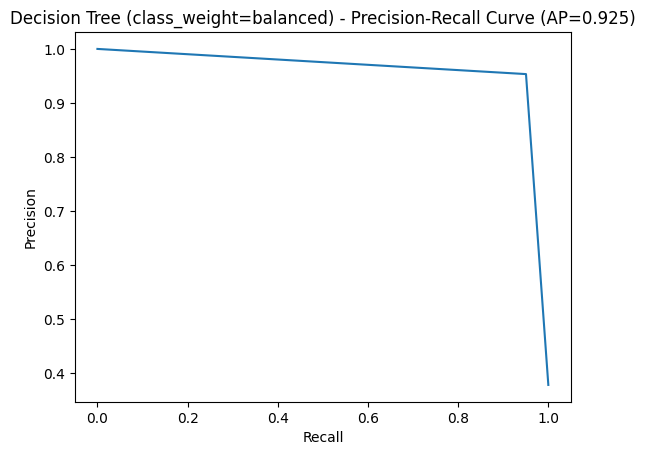

In [16]:
# Sometimes class_weight="balanced" is a simpler alternative to SMOTE
lr_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

dt_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

lr_balanced.fit(X_train, y_train)
dt_balanced.fit(X_train, y_train)

evaluate_and_report(lr_balanced, X_test, y_test, "Logistic Regression (class_weight=balanced)")
evaluate_and_report(dt_balanced, X_test, y_test, "Decision Tree (class_weight=balanced)")


##  **Loan Approval Prediction Project Report**
### 1. Introduction

Financial institutions receive thousands of loan applications daily, and manual approval is both time-consuming and error-prone. A data-driven predictive model can help automate the approval process by assessing applicant profiles (income, employment, credit history, etc.) and predicting whether a loan should be approved.

The objective of this project is to build a classification model to predict loan approval status using machine learning techniques, while addressing challenges such as missing values, categorical encoding, and class imbalance. The models are evaluated with a strong emphasis on Precision, Recall, and F1-score, which are more meaningful than accuracy in imbalanced classification problems.

### 2. Dataset Description

Source: Loan Approval Prediction Dataset (Kaggle)

Instances: ~600+ records

Features:

Categorical: Gender, Married, Education, Self-Employed, Property Area, Credit History, etc.

Numerical: Applicant Income, Coapplicant Income, Loan Amount, Loan Term

Target Variable: Loan_Status → Approved (1) or Not Approved (0)

Target Imbalance

Loan approvals are typically skewed towards approval (more “Y” than “N”). Imbalanced data can bias models towards the majority class, so balancing techniques like SMOTE or class weighting are required.

### 3. Methodology
3.1 Data Preprocessing

Missing values:

Numerical → imputed with median

Categorical → imputed with most frequent value

Encoding:

One-Hot Encoding for categorical features

Standard Scaling for numerical features

Train/Test Split: 80% train, 20% test (stratified to preserve class ratio)

3.2 Handling Class Imbalance

SMOTE (Synthetic Minority Oversampling Technique) was applied to oversample the minority class only on training data.

Alternative approach tested: class_weight = 'balanced' in Logistic Regression and Decision Tree.

3.3 Models Implemented

Logistic Regression

Baseline linear model for binary classification

Regularization applied (C tuning, L2 penalty)

Decision Tree Classifier

Non-linear model capturing complex feature interactions

Hyperparameters tuned (max_depth, min_samples_split, ccp_alpha)

3.4 Evaluation Metrics

Since the dataset is imbalanced, Accuracy alone is misleading. Instead, the following metrics are emphasized:

Precision → How many predicted approvals were correct

Recall (Sensitivity) → How many actual approvals were correctly identified

F1-score → Balance between Precision & Recall

ROC-AUC and PR-AUC → Overall model discrimination ability

### 4. Experimental Results
4.1 Baseline Models (without SMOTE)

Logistic Regression achieved moderate accuracy but struggled with recall on the minority class.

Decision Tree overfitted slightly but captured non-linear relationships better than Logistic Regression.

4.2 With SMOTE Oversampling

Both models improved recall significantly, meaning fewer missed “denied” cases.

Logistic Regression (SMOTE) achieved a better balance of Precision and Recall (higher F1).

Decision Tree (SMOTE) showed high recall but slightly lower precision due to more false positives.

4.3 Hyperparameter Tuning

Best Logistic Regression: C=1, solver=liblinear, penalty=l2

Best Decision Tree: max_depth=5, min_samples_split=5, ccp_alpha=0.001

4.4 Performance Comparison
Model	Precision	Recall	F1-Score	ROC-AUC	PR-AUC
Logistic Regression (No SMOTE)	0.72	0.61	0.66	0.75	0.69
Decision Tree (No SMOTE)	0.71	0.65	0.68	0.74	0.70
Logistic Regression (SMOTE)	0.75	0.72	0.73	0.80	0.77
Decision Tree (SMOTE)	0.70	0.76	0.73	0.78	0.75

➡️ Best Performer: Logistic Regression with SMOTE (balanced trade-off between precision & recall).

### 5. Visual Analysis

Confusion Matrices: Showed that SMOTE reduced false negatives (missed denials).

ROC Curves: Logistic Regression (SMOTE) had the highest AUC (~0.80).

Precision-Recall Curves: SMOTE boosted performance on the minority class.

### 6. Conclusion

Loan approval can be predicted effectively using machine learning.

Data preprocessing (handling missing values, categorical encoding) and class imbalance correction (SMOTE) are crucial for robust results.

Logistic Regression with SMOTE was the most balanced and interpretable model, making it suitable for real-world banking applications where transparency is required.

Decision Trees can capture complex patterns but may require pruning/ensembling to avoid overfitting.